In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tessla.tesssystem import TessSystem
from tessla.plotting_utils import sg_smoothing_plot, plot_individual_transits, quick_transit_plot, phase_plot
from tessla.plotting_utils import plot_joint_corners
from tessla.data_utils import find_breaks, quick_look_summary
from tessla.threepanelphotplot import ThreePanelPhotPlot
from tessla.rvplot import RVPlot
from tessla.planet import Planet
from tessla.stackedperiodogram import StackedPeriodogram

%load_ext autoreload
%autoreload 2

## System-specific parameters

In [2]:
SYSTEM_NAME = "TOI-669"
TIC_NUM = 124573851
TOI_NUM = 669

RV_DATA_PATH = 't000669_rv.csv'
MANUAL_PLANET_PATH = None
STAR_OBJ_PICKLE_PATH = 'T000669_iso_star_obj.pkl'
JMAG = 9.557
JMAG_ERR = 0.024

OUTPUT_DIR_SUFFIX = ''

COMPARE_AIC_FOR_TREND = True
NO_TREND_OVERRIDE = False
YES_TREND_OVERRIDE = False

INCLUDE_SVALUE_GP = False
FORCE_CIRCULAR_ORBITS = False

# Build the TOI object

In [4]:
toi = TessSystem(SYSTEM_NAME, 
                    tic=TIC_NUM, 
                    toi=TOI_NUM,
                    phot_gp_kernel='exp_decay',
                    rv_data_path=RV_DATA_PATH,
                    flux_origin="pdcsap_flux",
                    include_svalue_gp=INCLUDE_SVALUE_GP,
                    force_circular_orbits_for_transiting_planets=FORCE_CIRCULAR_ORBITS,
                    output_dir_suffix=OUTPUT_DIR_SUFFIX)

RV dataset detected. This will be a joint photometry-RV model.
Removed 0 RVs for being outliers.


## Quick inspection of the RVs and RV errors

In [5]:
import matplotlib.pyplot as plt
def simple_plot(df, xkey, ykey, xlabel, ylabel, yerrkey=None):
    for tel in np.unique(df.tel):
        mask = df.tel == tel
        if yerrkey is None:
            plt.plot(df.loc[mask, xkey], df.loc[mask, ykey], '.', label=tel)
        else:
            plt.errorbar(df.loc[mask, xkey], df.loc[mask, ykey], df.loc[mask, yerrkey], fmt='.', label=tel)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

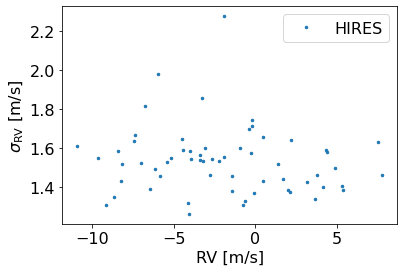

In [6]:
xkey = 'mnvel'
ykey = 'errvel'
xlabel = 'RV [m/s]'
ylabel = '$\sigma_\mathrm{RV}$ [m/s]'

simple_plot(toi.rv_df, xkey, ykey, xlabel, ylabel)

## Get the photometry

In [7]:
toi.get_tess_phot()
toi.search_for_tois()
toi.add_tois_from_catalog()

Found 6 data products for TIC 124573851:
SearchResult containing 6 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 09 2019      SPOC     120   124573851      0.0
  1 TESS Sector 09 2019 TESS-SPOC    1800   124573851      0.0
  2 TESS Sector 09 2019       QLP    1800   124573851      0.0
  3 TESS Sector 35 2021      SPOC     120   124573851      0.0
  4 TESS Sector 35 2021 TESS-SPOC     600   124573851      0.0
  5 TESS Sector 35 2021       QLP     600   124573851      0.0
Extracting all 120 s cadence data...
----------
Data that will be used for modeling:
SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 09 2019   SPOC     120   12

## Initial Savitsky-Golay outlier rejection

In [8]:
toi.initial_outlier_removal(positive_outliers_only=False, max_iters=10, sigma_thresh=3, time_window=1)

Must use an odd window size. Changing window size from 720 to 721.
SG smoothing and outlier removal converged after 3 iterations.
95 3-sigma outliers identified.


In [9]:
sg_smoothing_plot(toi)

SG smoothing plots saved to TOI-669/joint_model/plotting


In [10]:
toi.oot_periodogram(**{'label_peaks':False})

Periodogram plot saved to TOI-669/periodograms


(7.999515275649369,
 1.5,
 (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:title={'center':'TOI-669 OoT Photometry LS Periodogram'}, xlabel='Period [days]', ylabel='LS power'>))

## Add the star object

In [11]:
with open('T000669_iso_star_obj.pkl', 'rb') as star_fname:
        star = pickle.load(star_fname)
        star.inflate_star_mass_and_rad_errs() # Inflate the error bars on according to Tayar et al. 2022
        toi.add_star_props(star)

# So TSM value is calculated
toi.star.jmag = JMAG
toi.star.jmag_err = JMAG_ERR

In [12]:
toi.update_t0s_to_near_data_middle()

Planet b t0 updated from 1.44 to 368.34 [BJD - 2458544.70] to reduce P and t0 covariance.


## Initial transit fitting and outlier rejection

In [20]:
model = toi.flatten_light_curve()

Entering optimization and outlier rejection loop...
Optimization and outlier rejection iteration number 1.


optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -46243.807902110304 -> -43274.200855946205
optimizing logp for variables: [log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp]


message: Optimization terminated successfully.
logp: -43274.200855946205 -> -43240.18371830349
optimizing logp for variables: [log_ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -43240.18371830349 -> -43240.183347034086
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43240.183347034086 -> -43240.18330039327


optimizing logp for variables: [log_dur]


message: Desired error not necessarily achieved due to precision loss.
logp: -43240.18330039327 -> -43239.133497745664
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -43239.133497745664 -> -43238.06624012717
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: -43238.06624012716 -> -43237.983525644544


optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43237.983525644544 -> -43237.88790885584


optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43237.88790885584 -> -43237.88240448674


optimizing logp for variables: [log_dur]


message: Optimization terminated successfully.
logp: -43237.88240448674 -> -43237.84229616845
optimizing logp for variables: [mean_flux]


message: Optimization terminated successfully.
logp: -43237.84229616845 -> -43236.35415228329


optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -43236.35415228329 -> -43236.35412986808


optimizing logp for variables: [log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp]


message: Optimization terminated successfully.
logp: -43236.35412986808 -> -43236.09154897745
optimizing logp for variables: [log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp, log_sigma_phot, log_dur, b, log_ror, log_period, t0, u, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: -43236.091548977456 -> -43235.9527164249


MAP fitting and 7-sigma outlier removal converged in 1 iterations.
0 outlier(s) removed.
Updating transiting planet properties to MAP solution values


In [21]:
phot_plot = ThreePanelPhotPlot(toi,
                                use_broken_x_axis=True, 
                                plot_random_transit_draws=False,
                                num_random_transit_draws=0)

In [22]:
phot_plot.plot(save_fname=f"{toi.name.replace(' ', '_')}_phot_model_phot_only", 
               overwrite=True)

Creating three panel plot...
break_ind = 15172
Gap between 23.78 and 711.14 BTJD
Photometry model plot saved to TOI-669/joint_model/plotting/TOI-669_phot_model_phot_only.png


## Is an RV trend preferred?

In [23]:
if COMPARE_AIC_FOR_TREND:
    
    model_no_trend = toi.fit_phot_and_rvs(rv_trend=False)
    aic_no_trend = toi.compute_AIC(model_no_trend)
    msg_str = 'No trend AIC = '
    print(msg_str + f'{aic_no_trend:.2f}')
    
    model_yes_trend = toi.fit_phot_and_rvs(rv_trend=True)
    aic_yes_trend = toi.compute_AIC(model_yes_trend)
    msg_str = 'Yes trend AIC = '
    print(msg_str + f'{aic_yes_trend:.2f}')
    
    aic_difference = aic_no_trend - aic_yes_trend
    print(aic_difference)
    if aic_difference < 0:
        print("Trend is not preferred")
    else:
        print("Trend is preferred")

    if aic_difference < 0:
        model = toi.fit_phot_and_rvs(rv_trend=False)
    else:
        model = toi.fit_phot_and_rvs(rv_trend=True)
    aic = toi.compute_AIC(model)
    
elif NO_TREND_OVERRIDE:
    msg_str = 'No trend AIC = '
    model = toi.fit_phot_and_rvs(rv_trend=False)
    aic = toi.compute_AIC(model)
    print(msg_str + f'{aic:.2f}')
    
elif YES_TREND_OVERRIDE:
    msg_str = 'Yes trend AIC = '
    model = toi.fit_phot_and_rvs(rv_trend=True)
    aic = toi.compute_AIC(model)
    print(msg_str + f'{aic:.2f}')

optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -43587.204923205216 -> -43587.20461927584
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: -43587.20461927584 -> -43581.24945091413
optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43581.24945091413 -> -43573.10443774429
optimizing logp for variables: [log_K]


message: Optimization terminated successfully.
logp: -43573.10443774429 -> -43571.867121355324
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43571.867121355324 -> -43570.13907628202
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -43570.13907628202 -> -43566.48233776808
optimizing logp for variables: [gamma_rv]


message: Optimization terminated successfully.
logp: -43566.48233776808 -> -43531.30056115436
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -43531.30056115436 -> -43516.081840991974
optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43516.081840991974 -> -43513.059297863365
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43513.059297863365 -> -43512.81355972461
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -43512.81355972461 -> -43512.631318088854
optimizing logp for variables: [log_K]


message: Optimization terminated successfully.
logp: -43512.631318088854 -> -43512.18685729166
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: -43512.18685729166 -> -43511.92088276128
optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43511.92088276128 -> -43511.7501870036
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43511.7501870036 -> -43511.64243042147
optimizing logp for variables: [mean_flux]


message: Optimization terminated successfully.
logp: -43511.642430421474 -> -43511.64233776476


optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -43511.64233776476 -> -43511.64206588854


optimizing logp for variables: [log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp]


message: Optimization terminated successfully.
logp: -43511.64206588854 -> -43511.64195127694
optimizing logp for variables: [log_sigma_rv, gamma_rv, log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp, log_sigma_phot, ecs, b, log_ror, log_period, log_K, t0, rstar, mstar, u, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: -43511.64195127694 -> -43393.45631349859


Updating planet properties to MAP solution values
86822.91262699717


optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -43399.89935830218 -> -43399.89935830218


optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: -43399.89935830218 -> -43399.89935830218


optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43399.89935830218 -> -43399.89935830184


optimizing logp for variables: [log_K]


message: Optimization terminated successfully.
logp: -43399.89935830184 -> -43399.89935830184


optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43399.899358301845 -> -43399.899358301824


optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -43399.899358301824 -> -43399.899358301715


optimizing logp for variables: [trend_rv]


message: Optimization terminated successfully.
logp: -43399.899358301715 -> -43398.6460272719


optimizing logp for variables: [gamma_rv]


message: Optimization terminated successfully.
logp: -43398.6460272719 -> -43398.6460225208


optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -43398.6460225208 -> -43398.61402389756


optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43398.61402389756 -> -43398.61402389754
optimizing logp for variables: [b]


message: Desired error not necessarily achieved due to precision loss.
logp: -43398.61402389754 -> -43398.614023897455
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -43398.614023897455 -> -43398.61401240819
optimizing logp for variables: [log_K]


message: Optimization terminated successfully.
logp: -43398.61401240819 -> -43398.611401556496


optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: -43398.611401556496 -> -43398.61140150422


optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43398.61140150422 -> -43398.61140150265


optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43398.61140150265 -> -43398.611401497976
optimizing logp for variables: [mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: -43398.611401497976 -> -43398.61140149783
optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -43398.61140149783 -> -43398.61140149783


optimizing logp for variables: [log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: -43398.61140149783 -> -43398.6114014977
optimizing logp for variables: [log_sigma_rv, gamma_rv, trend_rv, log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp, log_sigma_phot, ecs, b, log_ror, log_period, log_K, t0, rstar, mstar, u, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: -43398.6114014977 -> -43398.59969960581


Updating planet properties to MAP solution values
86837.19939921163
-14.286772214458324
Trend is not preferred
86826.22954397998
-10.969855231654947
Trend is not preferred


optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -43395.114768883046 -> -43395.114768883046


optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: -43395.114768883046 -> -43395.114768883046


optimizing logp for variables: [log_ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -43395.114768883046 -> -43395.114768883046
optimizing logp for variables: [log_K]


message: Optimization terminated successfully.
logp: -43395.114768883046 -> -43395.11051064467
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43395.11051064467 -> -43395.11051064467


optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -43395.11051064467 -> -43395.10893893633
optimizing logp for variables: [gamma_rv]


message: Optimization terminated successfully.
logp: -43395.10893893633 -> -43393.50905324319


optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -43393.50905324319 -> -43393.472586755684
optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43393.472586755684 -> -43393.47258186376


optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43393.47258186376 -> -43393.4720389803
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -43393.4720389803 -> -43393.47202744411
optimizing logp for variables: [log_K]


message: Optimization terminated successfully.
logp: -43393.47202744411 -> -43393.461022801304
optimizing logp for variables: [u]


message: Optimization terminated successfully.
logp: -43393.461022801304 -> -43393.46101035765


optimizing logp for variables: [log_ror]


message: Optimization terminated successfully.
logp: -43393.46101035765 -> -43393.46099600551


optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -43393.46099600551 -> -43393.46099535784


optimizing logp for variables: [mean_flux]


message: Optimization terminated successfully.
logp: -43393.46099535784 -> -43393.46099535408


optimizing logp for variables: [log_sigma_phot]


message: Optimization terminated successfully.
logp: -43393.46099535408 -> -43393.46099535408


optimizing logp for variables: [log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp]


message: Optimization terminated successfully.
logp: -43393.46099535408 -> -43393.46099534381
optimizing logp for variables: [log_sigma_rv, gamma_rv, log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp, log_sigma_phot, ecs, b, log_ror, log_period, log_K, t0, rstar, mstar, u, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: -43393.46099534381 -> -43393.45631108795


Updating planet properties to MAP solution values


## Create initial MAP solution plots

In [24]:
stacked_pers = StackedPeriodogram(toi, min_period=1, max_period=1000, samples_per_peak=500)
stacked_pers.plot(save_fname=f"{toi.name.replace(' ', '_')}_stacked_periodogram", overwrite=True)

TOI-669 stacked periodogram plot saved to TOI-669/periodograms/TOI-669_stacked_periodogram.png


In [4]:
stacked_pers = StackedPeriodogram(toi, min_period=1, max_period=1000, samples_per_peak=1000, 
                                  plot_phot_vert_line=False, plot_phot_faps=True, faps=[0.001])
stacked_pers.plot(save_fname=f"{toi.name.replace(' ', '_')}_stacked_periodogram_new", overwrite=True)

TOI-669 stacked periodogram plot saved to TOI-669/periodograms/TOI-669_stacked_periodogram_new.png


In [25]:
quick_transit_plot(toi)

Initial transit fit plots saved to TOI-669/joint_model/plotting


In [26]:
plot_individual_transits(toi)

Plotting individual transits for TOI-669 b


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.12it/s]


Individual transit plots saved to TOI-669/joint_model/plotting/individual_transits/


In [27]:
phase_plot(os.path.join(toi.model_dir, 'plotting'), 
                f"{toi.name} {toi.flux_origin.replace('_', ' ')}", 
                'Relative flux [ppt]', 
                toi.cleaned_time.values, toi.cleaned_flux.values, toi.prot, 0)

Phase plot saved to TOI-669/joint_model/plotting/TOI-669_pdcsap_flux_phase_plot.png


In [4]:
use_broken_x_axis = len(find_breaks(toi.cleaned_time.values)) > 0

In [7]:
phot_plot = ThreePanelPhotPlot(toi,
                                use_broken_x_axis=use_broken_x_axis, 
                                plot_random_transit_draws=False,
                                num_random_transit_draws=0)

In [8]:
phot_plot.plot(save_fname=f"{toi.name.replace(' ', '_')}_phot_model", 
               overwrite=True)

Creating three panel plot...
break_ind = 15172
Gap between 23.78 and 711.14 BTJD
Photometry model plot saved to TOI-669/joint_model/plotting/TOI-669_phot_model_test.png


In [13]:
rv_plot = RVPlot(toi,
                plot_random_orbit_draws=False,
                num_random_orbit_draws=0,
                rms_yscale_phase_folded_panels=True)

In [14]:
rv_plot.plot(save_fname=f"{toi.name.replace(' ', '_')}_rv_model_test", 
             overwrite=True)

Creating RV plot...
RV model plot saved to TOI-669/joint_model/plotting/TOI-669_rv_model_test.png


In [ ]:
if INCLUDE_SVALUE_GP:
    svalue_plot = SvaluePlot(toi)
    svalue_plot.gp_plot(save_fname=f"{toi.name.replace(' ', '_')}_svalue", overwrite=True)

In [35]:
toi.map_soln

{'mean_flux': array(0.02229859),
 'u_quadlimbdark__': array([-0.55635801,  0.62603561]),
 'mstar_interval__': array(-0.84013549),
 'rstar_interval__': array(-0.70618696),
 't0': array([368.34062457]),
 'log_K': array([1.47968305]),
 'log_period': array([1.37248773]),
 'log_ror': array([-3.69045334]),
 'b_interval__': array([-0.69282484]),
 'ecs_unitdisk+interval__': array([[-0.44732519],
        [-0.04673187]]),
 'log_sigma_phot': array(-3.49045057),
 'log_sigma_phot_gp': array(-2.86548364),
 'log_rho_phot_gp_interval__': array(-0.59459995),
 'log_tau_phot_gp_interval__': array(-0.83453554),
 'gamma_rv_interval__': array([-0.09064735]),
 'log_sigma_rv_interval__': array([0.51926151]),
 'u': array([ 0.78666164, -0.18301392]),
 'mstar': array(0.90451874),
 'rstar': array(0.99132579),
 'K': array([4.39155354]),
 'period': array([3.94515296]),
 'ror': array([0.02496068]),
 'r_pl': array([0.02474417]),
 'b': array([0.33340497]),
 'ecs': array([[-0.22000617],
        [-0.02278929]]),
 'ecc':

# Run the sampling

In [36]:
flat_samps = toi.run_sampling(model, toi.map_soln, tune=8000, draws=6000, chains=8, overwrite=True)

Multiprocessing context has already been set. Continuing.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma_rv, gamma_rv, log_tau_phot_gp, log_rho_phot_gp, log_sigma_phot_gp, log_sigma_phot, ecs, b, log_ror, log_period, log_K, t0, rstar, mstar, u, mean_flux]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 677 seconds.


In [37]:
chains = pd.read_csv(toi.chains_path)

In [39]:
chains.head()

,mean_flux,u_0,u_1,mstar,rstar,t0_b,log_K_b,K_b,log_period_b,period_b,...,b_b,ecc_b,omega_b,log_sigma_phot,log_sigma_phot_gp,log_rho_phot_gp,log_tau_phot_gp,gamma_rv_HIRES,log_sigma_rv_b,sigma_rv_HIRES
0,0.057046,0.870397,-0.052315,0.901561,0.998743,368.336983,1.688605,5.411928,1.372477,3.945110,...,0.487156,0.191913,-2.598944,-3.197330,-2.752547,1.292012,0.384010,-2.586452,1.217411,3.378431
1,-0.002990,1.374686,-0.610181,0.873615,1.008341,368.338285,1.289646,3.631501,1.372481,3.945127,...,0.192593,0.011498,0.734649,-4.512320,-2.542292,0.705009,0.368737,-1.729033,0.857072,2.356252
2,-0.009544,1.314764,-0.641906,0.817043,0.992532,368.339227,1.369948,3.935144,1.372486,3.945145,...,0.174981,0.043303,2.166973,-3.690127,-2.513424,1.924457,2.599958,-1.720216,0.831024,2.295668
3,0.024854,0.381942,0.442625,0.990883,1.013161,368.341569,1.367572,3.925807,1.372480,3.945123,...,0.288747,0.068763,-2.392056,-3.567141,-2.811456,1.297490,0.205428,-2.369642,1.098992,3.001139
4,0.026887,0.849052,-0.372153,0.936395,0.988617,368.337827,1.492798,4.449526,1.372482,3.945129,...,0.199543,0.042582,3.070979,-3.091452,-2.624315,0.774273,0.047623,-2.573689,0.914589,2.495750


## Add derived quantities to the chains for convenience

In [40]:
toi.add_derived_quantities_to_chains()

In [41]:
chains_d = pd.read_csv(toi.chains_derived_path)

In [44]:
chains_d.head()

,mean_flux,u_0,u_1,mstar,rstar,t0_b,log_K_b,K_b,log_period_b,period_b,...,i_rad_b,i_deg_b,mp_b,rho_b,dur_day_b,dur_hr_b,dur_circ_day_b,dur_circ_hr_b,Rtau_Petigura2020_b,tsm_b
0,0.057046,0.870397,-0.052315,0.901561,0.998743,368.336983,1.688605,5.411928,1.372477,3.945110,...,1.522844,87.252548,12.261985,3.574918,0.117833,2.827989,0.123761,2.970273,0.952098,31.019143
1,-0.002990,1.374686,-0.610181,0.873615,1.008341,368.338285,1.289646,3.631501,1.372481,3.945127,...,1.551461,88.892170,8.201260,2.572087,0.122973,2.951354,0.126278,3.030664,0.973831,40.166048
2,-0.009544,1.314764,-0.641906,0.817043,0.992532,368.339227,1.369948,3.935144,1.372486,3.945145,...,1.553115,88.986912,8.491418,2.863103,0.120715,2.897159,0.127106,3.050541,0.949720,37.229876
3,0.024854,0.381942,0.442625,0.990883,1.013161,368.341569,1.367572,3.925807,1.372480,3.945123,...,1.542865,88.399643,9.622308,2.814951,0.121935,2.926442,0.121650,2.919591,1.002346,34.708513
4,0.026887,0.849052,-0.372153,0.936395,0.988617,368.337827,1.492798,4.449526,1.372482,3.945129,...,1.551604,88.900376,10.515606,3.540406,0.118079,2.833905,0.120960,2.903033,0.976188,30.753073


In [50]:
def print_med_and_errs(col, units):
    med = np.median(chains_d[col])
    q = np.quantile(chains_d[col], [0.16, 0.86])
    err = np.median(np.abs(q - med))
    print(f"{col} = {med:.2f} +/- {err:.2f} {units}")

In [51]:
print_med_and_errs('rp_b', 'Rearth')
print_med_and_errs('mp_b', 'Mearth')
print_med_and_errs('rho_b', 'gcc')
print_med_and_errs('K_b', 'm/s')
print_med_and_errs('tsm_b', '')

rp_b = 2.61 +/- 0.16 Rearth
mp_b = 9.84 +/- 1.48 Mearth
rho_b = 3.01 +/- 0.74 gcc
K_b = 4.29 +/- 0.64 m/s
tsm_b = 35.50 +/- 8.10 


## Produce a quick-look summary .csv file

In [42]:
quick_look_summary(toi, chains_d)

Quick look summary table saved to TOI-669/TOI-669_quick_look_summary.csv.


In [ ]:
df_summary_fname = f"{toi.name.replace(' ', '_')}{OUTPUT_DIR_SUFFIX}"
df_summary_fname += f"/{toi.name.replace(' ', '_')}_quick_look_summary.csv"

## Create some nice looking plots

In [4]:
phot_plot = ThreePanelPhotPlot(toi,
                                use_broken_x_axis=True, 
                                plot_random_transit_draws=True,
                                num_random_transit_draws=25, 
                                df_summary_fname=df_summary_fname)

In [5]:
phot_plot.plot(save_fname=f"{toi.name.replace(' ', '_')}_phot_model_w_samples", 
               overwrite=True)

Creating three panel plot...
break_ind = 15172
Gap between 23.78 and 711.14 BTJD
Plotting 25 random draws of phase-folded transit for planet b...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [18:32<00:00, 44.49s/it]


Photometry model plot saved to TOI-669/joint_model/plotting/TOI-669_phot_model_w_samples_lower_res_175.png


In [15]:
rv_plot = RVPlot(toi,
                plot_random_orbit_draws=True,
                num_random_orbit_draws=25, 
                df_summary_fname=df_summary_fname)

In [16]:
rv_plot.plot(save_fname=f"{toi.name.replace(' ', '_')}_rv_model_w_samples", overwrite=True)

Creating RV plot...
Plotting 25 random draws of phase-folded RV orbit for planet b...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:24<00:00,  8.18s/it]


RV model plot saved to TOI-669/joint_model/plotting/TOI-669_rv_model_w_samples.png


## Make the corner plots

In [52]:
plot_joint_corners(toi, chains_d, overwrite=True)

TOI-669 corner plot saved to TOI-669/joint_model/plotting/TOI-669_corner_plot.png
TOI-669 RV instrument parameters corner plot saved to TOI-669/joint_model/plotting/TOI-669_RV_instrument_parameters_corner_plot.png
TOI-669 b measured parameters corner plot saved to TOI-669/joint_model/plotting/TOI-669_b_measured_parameters_corner_plot.png
TOI-669 b derived parameters corner plot saved to TOI-669/joint_model/plotting/TOI-669_b_derived_parameters_corner_plot.png


# Pickle the map solution and the TOI object

In [53]:
with open(os.path.join(toi.output_dir, f"{toi.name.replace(' ', '_')}_map_soln.pkl"), "wb") as map_soln_fname:
    pickle.dump(toi.map_soln, map_soln_fname, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
with open(os.path.join(toi.output_dir, f"{toi.name.replace(' ', '_')}_toi_obj.pkl"), "wb") as toi_fname:
    pickle.dump(toi, toi_fname, protocol=pickle.HIGHEST_PROTOCOL)

## START HERE IF YOU'RE LOADING PICKLES

e.g., for post-processing of figures from a previous run

In [2]:
with open('TOI-669/TOI-669_toi_obj.pkl', 'rb') as f:
    toi = pickle.load(f)

In [3]:
df_summary_fname=f"{toi.name.replace(' ', '_')}/{toi.name.replace(' ', '_')}_quick_look_summary.csv"

In [6]:
rv_plot = RVPlot(toi,
                plot_random_orbit_draws=True,
                num_random_orbit_draws=25, 
                df_summary_fname=df_summary_fname,
                residuals_ytick_spacing=(10, 5))

rv_plot.plot(save_fname=f"{toi.name.replace(' ', '_')}_rv_model_w_samples_better_tick_spacing", overwrite=True)

Creating RV plot...
Plotting 25 random draws of phase-folded RV orbit for planet b...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.09it/s]


RV model plot saved to TOI-669/joint_model/plotting/TOI-669_rv_model_w_samples_better_tick_spacing.png
